In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [3]:
def split_train_test(data, n_steps):
	X, y = [], []
	for i in range(n_steps, len(data)):
		X.append(data[i-n_steps:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [4]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [5]:
def compare_mse_model(model,model_1):
    mse_error = [model,model_1]
    error = pd.DataFrame({"Model" : ['model','model_1'], "MSE error": mse_error})
    return error

In [6]:
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

# Train/Test Model

In [7]:
from sklearn.preprocessing import MinMaxScaler

train = cloud_cover[cloud_cover['DateTime'] < '2021-12-16 09:11:00']
test = cloud_cover[cloud_cover['DateTime'] >= '2021-12-16 09:11:00']

print('train Shape', train.shape)
print('test Shape', test.shape)

train = train.set_index('DateTime')
test = test.set_index('DateTime')

sc = MinMaxScaler()
sc.fit(train)
training_set_scaled = sc.transform(train)

train Shape (14769, 2)
test Shape (292, 2)


In [8]:
training_set_scaled

array([[0.98997494],
       [0.98897243],
       [0.98763576],
       ...,
       [0.34235589],
       [0.32631579],
       [0.10877193]])

In [9]:
X_train, y_train = split_train_test(training_set_scaled, 30)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(14739, 30, 1)
(14739, 1)


In [10]:
X_train

array([[[0.98997494],
        [0.98897243],
        [0.98763576],
        ...,
        [0.98997494],
        [0.99398496],
        [0.99632414]],

       [[0.98897243],
        [0.98763576],
        [0.98696742],
        ...,
        [0.99398496],
        [0.99632414],
        [0.99699248]],

       [[0.98763576],
        [0.98696742],
        [0.98696742],
        ...,
        [0.99632414],
        [0.99699248],
        [0.99532164]],

       ...,

       [[0.25213033],
        [0.21002506],
        [0.20100251],
        ...,
        [0.31929825],
        [0.30225564],
        [0.28421053]],

       [[0.21002506],
        [0.20100251],
        [0.21403509],
        ...,
        [0.30225564],
        [0.28421053],
        [0.34235589]],

       [[0.20100251],
        [0.21403509],
        [0.20902256],
        ...,
        [0.28421053],
        [0.34235589],
        [0.32631579]]])

In [11]:
dataset_total = pd.concat((train['cloud_cover'],test['cloud_cover']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [12]:
X_test, y_test = split_train_test(inputs, 30)
print(X_test.shape)
print(y_test.shape)

(292, 30, 1)
(292, 1)


In [13]:
X_test

array([[[0.21403509],
        [0.20902256],
        [0.20401003],
        ...,
        [0.34235589],
        [0.32631579],
        [0.10877193]],

       [[0.20902256],
        [0.20401003],
        [0.2       ],
        ...,
        [0.32631579],
        [0.10877193],
        [0.10977444]],

       [[0.20401003],
        [0.2       ],
        [0.19298246],
        ...,
        [0.10877193],
        [0.10977444],
        [0.11378446]],

       ...,

       [[0.17894737],
        [0.17593985],
        [0.17092732],
        ...,
        [0.16591479],
        [0.16591479],
        [0.16691729]],

       [[0.17593985],
        [0.17092732],
        [0.17192982],
        ...,
        [0.16591479],
        [0.16691729],
        [0.14486216]],

       [[0.17092732],
        [0.17192982],
        [0.17092732],
        ...,
        [0.16691729],
        [0.14486216],
        [0.14285714]]])

In [14]:
y_test

array([[0.10977444],
       [0.11378446],
       [0.10977444],
       [0.09674185],
       [0.09172932],
       [0.10877193],
       [0.11077694],
       [0.11679198],
       [0.11478697],
       [0.10977444],
       [0.11378446],
       [0.11779449],
       [0.11779449],
       [0.11879699],
       [0.12080201],
       [0.11278195],
       [0.13082707],
       [0.1358396 ],
       [0.14285714],
       [0.13383459],
       [0.13082707],
       [0.13483709],
       [0.13483709],
       [0.14486216],
       [0.1518797 ],
       [0.15388471],
       [0.15889724],
       [0.15989975],
       [0.15388471],
       [0.15889724],
       [0.15689223],
       [0.16390977],
       [0.14887218],
       [0.13684211],
       [0.15388471],
       [0.16491228],
       [0.17794486],
       [0.17192982],
       [0.17994987],
       [0.19598997],
       [0.22406015],
       [0.23909774],
       [0.2481203 ],
       [0.26616541],
       [0.27919799],
       [0.28421053],
       [0.28320802],
       [0.291

## Add frist layer: units = 50

In [15]:
from keras.layers import Dropout

In [16]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
461/461 [==============================] - 14s 20ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 2/30
461/461 [==============================] - 8s 17ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 3/30
461/461 [==============================] - 8s 17ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 4/30
461/461 [==============================] - 9s 20ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/30
461/461 [==============================] - 10s 21ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/30
461/461 [==============================] - 9s 20ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 7/30
461/461 [==============================] - 10s 21ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/30
461/461 [==============================] - 9s 19ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/30
461/461 [==============================] - 11s 23ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/30
461/461 [==============================] - 8s 18ms/step - loss: 0.0012 - va

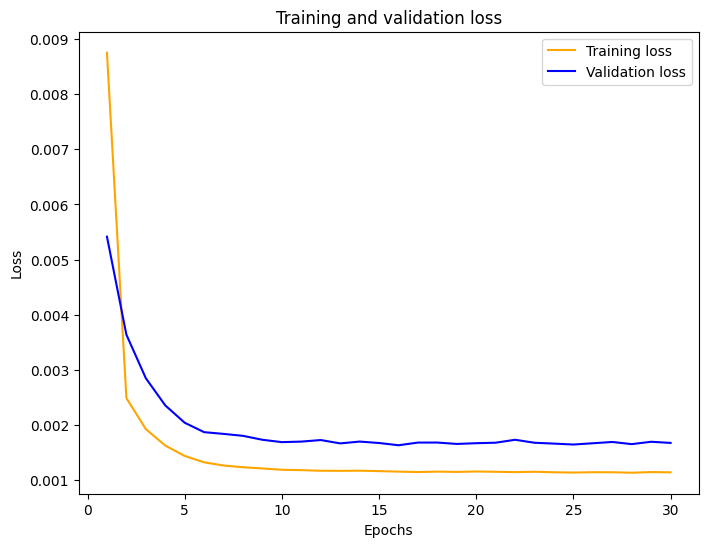

In [19]:
plot_curve(hist)

In [28]:
predict_scaled = regressor.predict(X_test)
predict_scaled

10/10 [==============================] - 0s 10ms/step


array([[0.12425004],
       [0.11776398],
       [0.11929798],
       [0.11478776],
       [0.10229255],
       [0.09662701],
       [0.11114807],
       [0.11308789],
       [0.1185059 ],
       [0.11671863],
       [0.11206247],
       [0.11551079],
       [0.11915681],
       [0.11926128],
       [0.12024117],
       [0.12212756],
       [0.11486399],
       [0.13122869],
       [0.1361834 ],
       [0.14303342],
       [0.13506243],
       [0.13232607],
       [0.13590483],
       [0.13595329],
       [0.14525016],
       [0.1520046 ],
       [0.15420525],
       [0.1591171 ],
       [0.16030003],
       [0.15492828],
       [0.15957145],
       [0.15780616],
       [0.16436426],
       [0.15062733],
       [0.13935862],
       [0.1545506 ],
       [0.16493018],
       [0.17744645],
       [0.17232072],
       [0.18003507],
       [0.19525072],
       [0.22212765],
       [0.23704767],
       [0.2464259 ],
       [0.26431176],
       [0.27733582],
       [0.28278455],
       [0.282

In [27]:
predict = sc.inverse_transform(predict_scaled)
predict.shape

(292, 1)

In [22]:
test['LSTM'] = predict
test.reset_index(inplace=True)
test

DateTime  cloud_cover      LSTM
0   2021-12-16 09:11:00        0.112  0.126439
1   2021-12-16 09:12:00        0.116  0.119970
2   2021-12-16 09:13:00        0.112  0.121500
3   2021-12-16 09:14:00        0.099  0.117001
4   2021-12-16 09:15:00        0.094  0.104537
..                  ...          ...       ...
287 2021-12-16 13:58:00        0.168  0.169258
288 2021-12-16 13:59:00        0.169  0.169200
289 2021-12-16 14:00:00        0.147  0.170080
290 2021-12-16 14:01:00        0.145  0.149762
291 2021-12-16 14:02:00        0.144  0.147356

[292 rows x 3 columns]

In [23]:
train.reset_index(inplace=True)
train

DateTime  cloud_cover
0     2021-11-16 11:15:00     0.990000
1     2021-11-16 11:16:00     0.989000
2     2021-11-16 11:17:00     0.987667
3     2021-11-16 11:18:00     0.987000
4     2021-11-16 11:19:00     0.987000
...                   ...          ...
14764 2021-12-15 16:56:00     0.304000
14765 2021-12-15 16:57:00     0.286000
14766 2021-12-15 16:58:00     0.344000
14767 2021-12-15 16:59:00     0.328000
14768 2021-12-16 09:10:00     0.111000

[14769 rows x 2 columns]

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [26]:
lstm_mse_error_unit_50 = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM'])
print()
print(f'MSE Error: {lstm_mse_error_unit_50}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.0016701268079067724
RMSE Error: 0.04086718497654044
MAE: 0.010176968328348579
r2_score: 0.9355274943917078


----------------------------------------------------------------------------------

## Add frist layer: units = 100

In [29]:
regressor_1 = Sequential()
regressor_1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_1.add(Dense(units = 1))
regressor_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [30]:
hist_1 = regressor_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
461/461 [==============================] - 18s 28ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 2/30
461/461 [==============================] - 11s 23ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 3/30
461/461 [==============================] - 16s 35ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/30
461/461 [==============================] - 10s 22ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/30
461/461 [==============================] - 10s 21ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/30
461/461 [==============================] - 10s 21ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/30
461/461 [==============================] - 9s 19ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/30
461/461 [==============================] - 8s 17ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/30
461/461 [==============================] - 8s 18ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/30
461/461 [==============================] - 8s 18ms/step - loss: 0.0012 - 

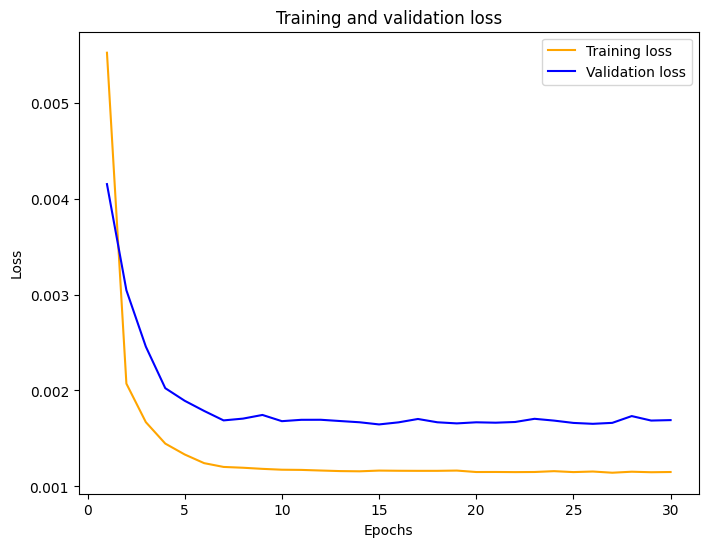

In [32]:
plot_curve(hist_1)

In [33]:
predict_scaled_1 = regressor_1.predict(X_test)
predict_scaled_1

10/10 [==============================] - 1s 6ms/step


array([[0.12316959],
       [0.10888532],
       [0.11326342],
       [0.10997406],
       [0.09761301],
       [0.09194369],
       [0.10707008],
       [0.10975611],
       [0.11542179],
       [0.11392891],
       [0.10927927],
       [0.112812  ],
       [0.1168132 ],
       [0.11709484],
       [0.11808304],
       [0.12002893],
       [0.11273149],
       [0.12905738],
       [0.13462834],
       [0.14147866],
       [0.13347267],
       [0.13027143],
       [0.13383837],
       [0.13404575],
       [0.14338428],
       [0.15043087],
       [0.15268703],
       [0.15751016],
       [0.15872447],
       [0.15320982],
       [0.1576128 ],
       [0.15599082],
       [0.16246594],
       [0.14879875],
       [0.13687679],
       [0.15201941],
       [0.16313186],
       [0.17592171],
       [0.17095616],
       [0.17826661],
       [0.19372977],
       [0.22104207],
       [0.23661521],
       [0.24605256],
       [0.2637683 ],
       [0.27703032],
       [0.2825249 ],
       [0.281

In [34]:
predict_1 = sc.inverse_transform(predict_scaled_1)
predict_1

array([[0.12536167],
       [0.1111131 ],
       [0.11548026],
       [0.11219913],
       [0.09986898],
       [0.09421383],
       [0.1093024 ],
       [0.11198172],
       [0.11763323],
       [0.11614408],
       [0.11150607],
       [0.11502998],
       [0.11902116],
       [0.11930211],
       [0.12028783],
       [0.12222885],
       [0.11494967],
       [0.13123474],
       [0.13679178],
       [0.14362496],
       [0.135639  ],
       [0.13244577],
       [0.13600378],
       [0.13621064],
       [0.14552583],
       [0.1525548 ],
       [0.15480532],
       [0.1596164 ],
       [0.16082767],
       [0.1553268 ],
       [0.15971877],
       [0.15810086],
       [0.16455978],
       [0.15092675],
       [0.1390346 ],
       [0.15413937],
       [0.16522405],
       [0.17798191],
       [0.17302878],
       [0.18032095],
       [0.19574545],
       [0.22298947],
       [0.23852368],
       [0.24793744],
       [0.26560885],
       [0.27883774],
       [0.2843186 ],
       [0.283

In [35]:
test['LSTM_1'] = predict_1
test

DateTime  cloud_cover      LSTM    LSTM_1
0   2021-12-16 09:11:00        0.112  0.125970  0.125362
1   2021-12-16 09:12:00        0.116  0.117817  0.111113
2   2021-12-16 09:13:00        0.112  0.119682  0.115480
3   2021-12-16 09:14:00        0.099  0.115831  0.112199
4   2021-12-16 09:15:00        0.094  0.103607  0.099869
..                  ...          ...       ...       ...
287 2021-12-16 13:58:00        0.168  0.170005  0.167051
288 2021-12-16 13:59:00        0.169  0.169940  0.166945
289 2021-12-16 14:00:00        0.147  0.170841  0.167865
290 2021-12-16 14:01:00        0.145  0.150415  0.147440
291 2021-12-16 14:02:00        0.144  0.147742  0.144406

[292 rows x 4 columns]

In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM_1'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [37]:
lstm_mse_error_unit_100 = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_1'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_1'])
print()
print(f'MSE Error: {lstm_mse_error_unit_100}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.0016829632219464458
RMSE Error: 0.041023934744810205
MAE: 0.010024529031490629
r2_score: 0.9350319656855968


In [38]:
compare_mse_model(lstm_mse_error_unit_50,lstm_mse_error_unit_100)

Model  MSE error
0    model   0.001667
1  model_1   0.001683

------------

## Add frist layer: units = 50 and Add Dropout = 0.1

In [39]:
regressor_2 = Sequential()
regressor_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_2.add(Dropout(0.1))
regressor_2.add(Dense(units = 1))
regressor_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [40]:
hist_2 = regressor_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32)

Epoch 1/30
461/461 [==============================] - 11s 15ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 2/30
461/461 [==============================] - 6s 13ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 3/30
461/461 [==============================] - 6s 13ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 4/30
461/461 [==============================] - 7s 15ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/30
461/461 [==============================] - 7s 15ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/30
461/461 [==============================] - 7s 15ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/30
461/461 [==============================] - 8s 16ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/30
461/461 [==============================] - 8s 17ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/30
461/461 [==============================] - 6s 13ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/30
461/461 [==============================] - 7s 15ms/step - loss: 0.0017 - val_l

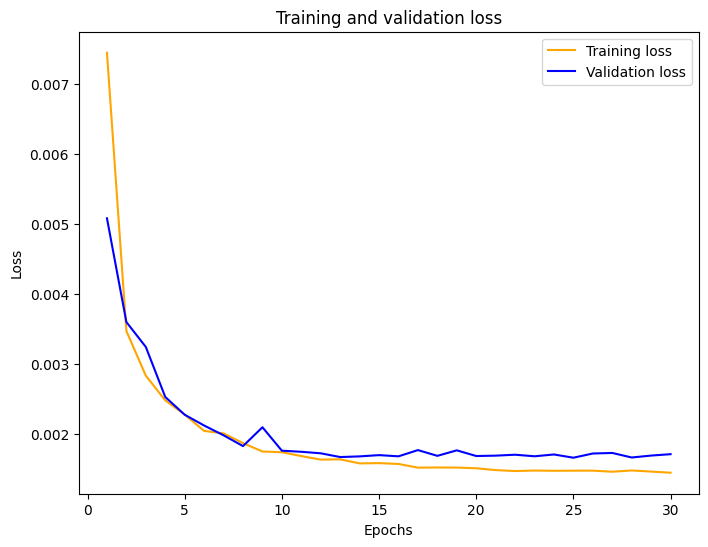

In [41]:
plot_curve(hist_2)

In [42]:
predict_scaled_2 = regressor_2.predict(X_test)
predict_scaled_2

10/10 [==============================] - 1s 5ms/step


array([[0.12794834],
       [0.11699045],
       [0.11823195],
       [0.11293459],
       [0.09924269],
       [0.09252146],
       [0.10637936],
       [0.10819742],
       [0.1134727 ],
       [0.11193395],
       [0.10754505],
       [0.11116758],
       [0.11513487],
       [0.1155006 ],
       [0.11660272],
       [0.11860371],
       [0.11155674],
       [0.12764463],
       [0.13292846],
       [0.13974237],
       [0.13207003],
       [0.12928995],
       [0.13289663],
       [0.13307634],
       [0.14224741],
       [0.14905658],
       [0.15130797],
       [0.15620637],
       [0.15752217],
       [0.1523239 ],
       [0.15688458],
       [0.155272  ],
       [0.16170713],
       [0.14825645],
       [0.13686752],
       [0.15171027],
       [0.1621317 ],
       [0.17446712],
       [0.16954282],
       [0.1771397 ],
       [0.1923711 ],
       [0.21911208],
       [0.2341331 ],
       [0.24375562],
       [0.2618003 ],
       [0.2750799 ],
       [0.28092012],
       [0.281

In [43]:
predict_2 = sc.inverse_transform(predict_scaled_2)
predict_2

array([[0.13012847],
       [0.11919797],
       [0.12043637],
       [0.11515225],
       [0.10149458],
       [0.09479015],
       [0.10861341],
       [0.11042693],
       [0.11568902],
       [0.11415411],
       [0.10977618],
       [0.11338966],
       [0.11734702],
       [0.11771184],
       [0.11881121],
       [0.12080719],
       [0.11377785],
       [0.12982552],
       [0.13509615],
       [0.14189303],
       [0.13423987],
       [0.13146673],
       [0.1350644 ],
       [0.13524365],
       [0.14439179],
       [0.15118395],
       [0.1534297 ],
       [0.15831585],
       [0.15962838],
       [0.1544431 ],
       [0.15899238],
       [0.15738383],
       [0.16380288],
       [0.15038581],
       [0.13902536],
       [0.153831  ],
       [0.16422637],
       [0.17653096],
       [0.17161897],
       [0.17919685],
       [0.19439018],
       [0.22106431],
       [0.23604777],
       [0.24564624],
       [0.26364577],
       [0.2768922 ],
       [0.2827178 ],
       [0.282

In [44]:
test['LSTM_2'] = predict_2
test

DateTime  cloud_cover      LSTM    LSTM_1    LSTM_2
0   2021-12-16 09:11:00        0.112  0.125970  0.125362  0.130128
1   2021-12-16 09:12:00        0.116  0.117817  0.111113  0.119198
2   2021-12-16 09:13:00        0.112  0.119682  0.115480  0.120436
3   2021-12-16 09:14:00        0.099  0.115831  0.112199  0.115152
4   2021-12-16 09:15:00        0.094  0.103607  0.099869  0.101495
..                  ...          ...       ...       ...       ...
287 2021-12-16 13:58:00        0.168  0.170005  0.167051  0.166576
288 2021-12-16 13:59:00        0.169  0.169940  0.166945  0.166469
289 2021-12-16 14:00:00        0.147  0.170841  0.167865  0.167329
290 2021-12-16 14:01:00        0.145  0.150415  0.147440  0.147290
291 2021-12-16 14:02:00        0.144  0.147742  0.144406  0.144587

[292 rows x 5 columns]

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM_2'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [46]:
lstm_mse_error_50_drop_out = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_2'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_2'])
print()
print(f'MSE Error: {lstm_mse_error_50_drop_out}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.001697151496285546
RMSE Error: 0.0411964985925448
MAE: 0.010535512513902091
r2_score: 0.9344842506303274


In [47]:
compare_mse_model(lstm_mse_error_unit_50,lstm_mse_error_50_drop_out)

Model  MSE error
0    model   0.001667
1  model_1   0.001697

------------------------------------

## Add frist layer: units = 50 and change epochs from 30 to 50

In [48]:
regressor_3 = Sequential()
regressor_3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_3.add(Dense(units = 1))
regressor_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [49]:
hist_3 = regressor_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 50, batch_size = 32)

Epoch 1/50
461/461 [==============================] - 12s 17ms/step - loss: 0.0140 - val_loss: 0.0065
Epoch 2/50
461/461 [==============================] - 6s 14ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 3/50
461/461 [==============================] - 6s 14ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 4/50
461/461 [==============================] - 6s 13ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 5/50
461/461 [==============================] - 6s 13ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/50
461/461 [==============================] - 6s 13ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 7/50
461/461 [==============================] - 5s 12ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
461/461 [==============================] - 5s 12ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/50
461/461 [==============================] - 5s 11ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
461/461 [==============================] - 6s 12ms/step - loss: 0.0012 - val_l

In [109]:
# regressor_3.save('lstm_test_one_day.h5')

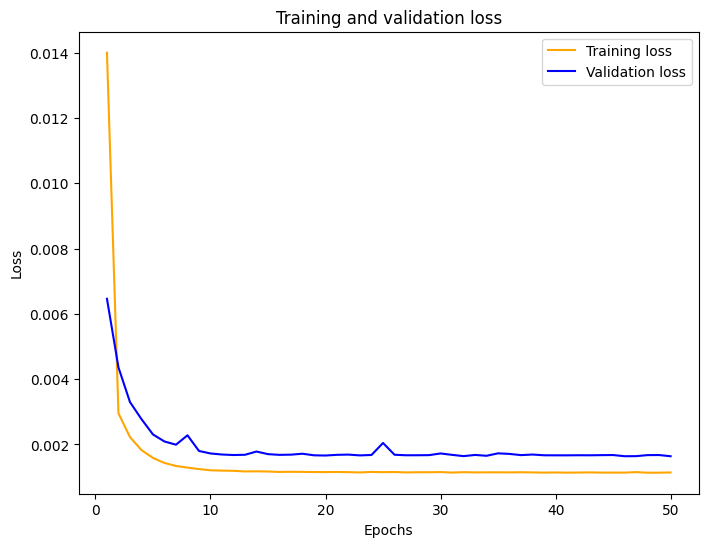

In [50]:
plot_curve(hist_3)

In [51]:
predict_scaled_3 = regressor_3.predict(X_test)
predict_scaled_3

10/10 [==============================] - 1s 4ms/step


array([[0.11872243],
       [0.12326065],
       [0.12169499],
       [0.11944979],
       [0.10508413],
       [0.09722678],
       [0.11037954],
       [0.11047632],
       [0.11654612],
       [0.11464314],
       [0.11073997],
       [0.11516777],
       [0.11903825],
       [0.11926063],
       [0.12036896],
       [0.12216458],
       [0.11454335],
       [0.13199016],
       [0.13549778],
       [0.14258723],
       [0.13372116],
       [0.13167918],
       [0.13543847],
       [0.13541932],
       [0.14509785],
       [0.15115364],
       [0.15304011],
       [0.15793413],
       [0.15887377],
       [0.15361251],
       [0.15892355],
       [0.15677305],
       [0.16388316],
       [0.14920814],
       [0.13881922],
       [0.15480548],
       [0.1641487 ],
       [0.1766247 ],
       [0.17033301],
       [0.17874426],
       [0.19362585],
       [0.22061849],
       [0.234558  ],
       [0.24390224],
       [0.26177406],
       [0.27437526],
       [0.2800413 ],
       [0.279

In [52]:
predict_3 = sc.inverse_transform(predict_scaled_3)
predict_3

array([[0.12092562],
       [0.1254525 ],
       [0.12389075],
       [0.12165116],
       [0.10732142],
       [0.09948371],
       [0.11260359],
       [0.11270012],
       [0.11875475],
       [0.11685653],
       [0.11296312],
       [0.11737984],
       [0.12124065],
       [0.12146248],
       [0.12256804],
       [0.12435917],
       [0.11675699],
       [0.13416019],
       [0.13765904],
       [0.14473076],
       [0.13588686],
       [0.13384998],
       [0.13759989],
       [0.13758078],
       [0.14723511],
       [0.15327576],
       [0.15515752],
       [0.1600393 ],
       [0.16097659],
       [0.15572849],
       [0.16102625],
       [0.15888111],
       [0.16597345],
       [0.15133514],
       [0.14097218],
       [0.15691847],
       [0.16623834],
       [0.17868315],
       [0.17240718],
       [0.1807974 ],
       [0.19564179],
       [0.22256695],
       [0.23647161],
       [0.2457925 ],
       [0.26361963],
       [0.2761893 ],
       [0.2818412 ],
       [0.281

In [53]:
test['LSTM_3'] = predict_3
test

DateTime  cloud_cover      LSTM    LSTM_1    LSTM_2    LSTM_3
0   2021-12-16 09:11:00        0.112  0.125970  0.125362  0.130128  0.120926
1   2021-12-16 09:12:00        0.116  0.117817  0.111113  0.119198  0.125453
2   2021-12-16 09:13:00        0.112  0.119682  0.115480  0.120436  0.123891
3   2021-12-16 09:14:00        0.099  0.115831  0.112199  0.115152  0.121651
4   2021-12-16 09:15:00        0.094  0.103607  0.099869  0.101495  0.107321
..                  ...          ...       ...       ...       ...       ...
287 2021-12-16 13:58:00        0.168  0.170005  0.167051  0.166576  0.168354
288 2021-12-16 13:59:00        0.169  0.169940  0.166945  0.166469  0.168358
289 2021-12-16 14:00:00        0.147  0.170841  0.167865  0.167329  0.169152
290 2021-12-16 14:01:00        0.145  0.150415  0.147440  0.147290  0.148300
291 2021-12-16 14:02:00        0.144  0.147742  0.144406  0.144587  0.147394

[292 rows x 6 columns]

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM_3'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [55]:
lstm_mse_error_unit_50_epoch50 = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_3'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_3'])
print()
print(f'MSE Error: {lstm_mse_error_unit_50_epoch50}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.0016314782238857285
RMSE Error: 0.04039156129547023
MAE: 0.010807543523915828
r2_score: 0.9370194595755804


In [56]:
compare_mse_model(lstm_mse_error_unit_50,lstm_mse_error_unit_50_epoch50)

Model  MSE error
0    model   0.001667
1  model_1   0.001631

---

## Add frist layer: units = 50 and Add second layer: unit = 50 and epoch 50

In [57]:
regressor_4 = Sequential()
regressor_4.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor_4.add(LSTM(units = 50))
regressor_4.add(Dense(units = 1))
regressor_4.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [58]:
hist_4 = regressor_4.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 50, batch_size = 32)

Epoch 1/50
461/461 [==============================] - 26s 38ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 2/50
461/461 [==============================] - 14s 31ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 3/50
461/461 [==============================] - 12s 25ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/50
461/461 [==============================] - 13s 29ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/50
461/461 [==============================] - 14s 30ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/50
461/461 [==============================] - 13s 29ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/50
461/461 [==============================] - 14s 29ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/50
461/461 [==============================] - 15s 32ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/50
461/461 [==============================] - 10s 23ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/50
461/461 [==============================] - 11s 23ms/step - loss: 0.001

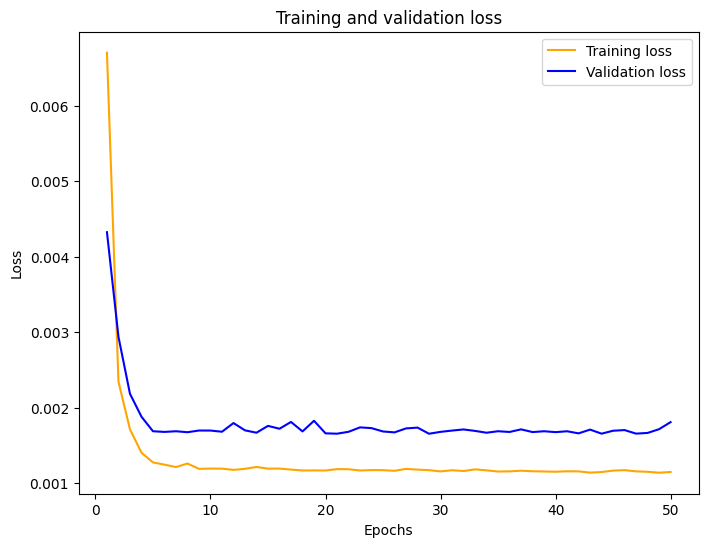

In [59]:
plot_curve(hist_4)

In [60]:
predict_scaled_4 = regressor_4.predict(X_test)
predict_4 = sc.inverse_transform(predict_scaled_4)
predict_4

10/10 [==============================] - 1s 18ms/step


array([[0.14978565],
       [0.13462287],
       [0.13158408],
       [0.13110387],
       [0.12042355],
       [0.11464252],
       [0.12713899],
       [0.12924333],
       [0.13490164],
       [0.1334159 ],
       [0.1292772 ],
       [0.13221392],
       [0.13567396],
       [0.13613752],
       [0.13710871],
       [0.13879074],
       [0.13215137],
       [0.14692622],
       [0.15190071],
       [0.15898871],
       [0.15176709],
       [0.1489427 ],
       [0.15175197],
       [0.15199341],
       [0.16075553],
       [0.16733584],
       [0.16986622],
       [0.17447703],
       [0.17565416],
       [0.17078184],
       [0.17478584],
       [0.17317834],
       [0.17939493],
       [0.16685331],
       [0.15608913],
       [0.16918164],
       [0.17932786],
       [0.19202432],
       [0.18777657],
       [0.19474751],
       [0.20873968],
       [0.23465766],
       [0.24985953],
       [0.2593745 ],
       [0.2759971 ],
       [0.2884975 ],
       [0.29401267],
       [0.293

In [61]:
test['LSTM_4'] = predict_4
test

DateTime  cloud_cover      LSTM    LSTM_1    LSTM_2    LSTM_3  \
0   2021-12-16 09:11:00        0.112  0.125970  0.125362  0.130128  0.120926   
1   2021-12-16 09:12:00        0.116  0.117817  0.111113  0.119198  0.125453   
2   2021-12-16 09:13:00        0.112  0.119682  0.115480  0.120436  0.123891   
3   2021-12-16 09:14:00        0.099  0.115831  0.112199  0.115152  0.121651   
4   2021-12-16 09:15:00        0.094  0.103607  0.099869  0.101495  0.107321   
..                  ...          ...       ...       ...       ...       ...   
287 2021-12-16 13:58:00        0.168  0.170005  0.167051  0.166576  0.168354   
288 2021-12-16 13:59:00        0.169  0.169940  0.166945  0.166469  0.168358   
289 2021-12-16 14:00:00        0.147  0.170841  0.167865  0.167329  0.169152   
290 2021-12-16 14:01:00        0.145  0.150415  0.147440  0.147290  0.148300   
291 2021-12-16 14:02:00        0.144  0.147742  0.144406  0.144587  0.147394   

       LSTM_4  
0    0.149786  
1    0.134623  
2    0.131584  
3    0.131104  
4    0.120424  
..        ...  
287  0.182380  
288  0.182274  
289  0.183015  
290  0.164259  
291  0.161263  

[292 rows x 7 columns]

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM_4'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [89]:
lstm_mse_error_second_layer = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_4'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_4'])
print()
print(f'MSE Error: {lstm_mse_error_second_layer}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.0018021142879277206
RMSE Error: 0.04245131668073113
MAE: 0.01840491763900404
r2_score: 0.9304323342484248


In [90]:
compare_mse_model(lstm_mse_error_unit_50_epoch50,lstm_mse_error_second_layer)

Model  MSE error
0    model   0.001631
1  model_1   0.001802

---

## Add frist layer: units = 50 and Add second layer: unit = 100 and epoch 30

In [101]:
regressor_5 = Sequential()
regressor_5.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor_5.add(LSTM(units = 100))
regressor_5.add(Dense(units = 1))
regressor_5.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [102]:
hist_5 = regressor_5.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs = 50, batch_size = 32)

Epoch 1/50
461/461 [==============================] - 23s 37ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 2/50
461/461 [==============================] - 15s 33ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 3/50
461/461 [==============================] - 14s 30ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/50
461/461 [==============================] - 16s 34ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/50
461/461 [==============================] - 15s 33ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 6/50
461/461 [==============================] - 14s 31ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/50
461/461 [==============================] - 14s 31ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/50
461/461 [==============================] - 14s 31ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/50
461/461 [==============================] - 14s 31ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/50
461/461 [==============================] - 14s 31ms/step - loss: 0.001

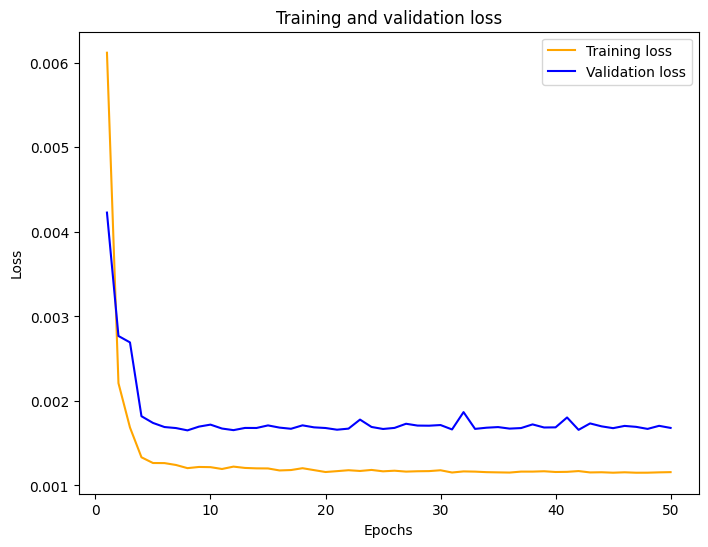

In [103]:
plot_curve(hist_5)

In [104]:
predict_scaled_5 = regressor_5.predict(X_test)
predict_5 = sc.inverse_transform(predict_scaled_5)
predict_5

10/10 [==============================] - 1s 24ms/step


array([[0.13651592],
       [0.12385122],
       [0.1127357 ],
       [0.1109551 ],
       [0.10179436],
       [0.09523719],
       [0.10594814],
       [0.10762826],
       [0.11468026],
       [0.11452391],
       [0.11133652],
       [0.11443076],
       [0.11753758],
       [0.11786933],
       [0.11874338],
       [0.12014786],
       [0.1133258 ],
       [0.12807319],
       [0.13254912],
       [0.14009508],
       [0.13279463],
       [0.13013907],
       [0.13270405],
       [0.13295364],
       [0.14199895],
       [0.14847964],
       [0.15100515],
       [0.1555871 ],
       [0.15664628],
       [0.1519898 ],
       [0.15627913],
       [0.15456213],
       [0.16098727],
       [0.14826815],
       [0.13776374],
       [0.15035038],
       [0.16008365],
       [0.17352226],
       [0.16935286],
       [0.17639326],
       [0.18997465],
       [0.21648757],
       [0.23250124],
       [0.24266313],
       [0.25924274],
       [0.271436  ],
       [0.27749994],
       [0.277

In [105]:
test['LSTM_5'] = predict_5
test

DateTime  cloud_cover      LSTM    LSTM_1    LSTM_2    LSTM_3  \
0   2021-12-16 09:11:00        0.112  0.125970  0.125362  0.130128  0.120926   
1   2021-12-16 09:12:00        0.116  0.117817  0.111113  0.119198  0.125453   
2   2021-12-16 09:13:00        0.112  0.119682  0.115480  0.120436  0.123891   
3   2021-12-16 09:14:00        0.099  0.115831  0.112199  0.115152  0.121651   
4   2021-12-16 09:15:00        0.094  0.103607  0.099869  0.101495  0.107321   
..                  ...          ...       ...       ...       ...       ...   
287 2021-12-16 13:58:00        0.168  0.170005  0.167051  0.166576  0.168354   
288 2021-12-16 13:59:00        0.169  0.169940  0.166945  0.166469  0.168358   
289 2021-12-16 14:00:00        0.147  0.170841  0.167865  0.167329  0.169152   
290 2021-12-16 14:01:00        0.145  0.150415  0.147440  0.147290  0.148300   
291 2021-12-16 14:02:00        0.144  0.147742  0.144406  0.144587  0.147394   

       LSTM_4    LSTM_5  
0    0.149786  0.136516  
1    0.134623  0.123851  
2    0.131584  0.112736  
3    0.131104  0.110955  
4    0.120424  0.101794  
..        ...       ...  
287  0.182380  0.164217  
288  0.182274  0.164021  
289  0.183015  0.164581  
290  0.164259  0.145903  
291  0.161263  0.143177  

[292 rows x 8 columns]

In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['cloud_cover'], name = 'Actual'))
fig.add_trace(go.Scatter(mode = 'lines', x = test['DateTime'], y = test['LSTM_5'], name = 'predict'))
fig.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [107]:
lstm_mse_error_second_layer100 = mean_squared_error(test['cloud_cover'], test['LSTM_5'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_5'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_5'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_5'])
print()
print(f'MSE Error: {lstm_mse_error_second_layer100}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.0016723931972421825
RMSE Error: 0.04089490429432722
MAE: 0.012899684426923323
r2_score: 0.9354400041493824


In [108]:
compare_mse_model(lstm_mse_error_unit_50_epoch50,lstm_mse_error_second_layer100)

Model  MSE error
0    model   0.001631
1  model_1   0.001672